In [60]:
# Importing standard Qiskit libraries:
import numpy as np     
from qiskit import QuantumCircuit, transpile, Aer, IBMQ, execute, assemble
from qiskit.quantum_info import Statevector
from qiskit.providers.ibmq import least_busy
from qiskit.opflow import Z, PauliExpectation
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit import QuantumRegister
from qiskit import ClassicalRegister
from ibm_quantum_widgets import *

# Loading your IBM Quantum account(s):
provider = IBMQ.load_account()

ibmqfactory.load_account:WARNING:2023-07-12 14:37:41,734: Credentials are already in use. The existing account in the session will be replaced.


In [61]:
# Number of qubits in the system.
L = 4

In [96]:
gamma_l = 0.1
gamma_r = 0.1

In [62]:
def zz_circuit(qubit_0,qubit_1,delta):
    qc_zz = QuantumCircuit(L)
    qc_zz.cx(qubit_0,qubit_1)
    qc_zz.rz(2*delta,qubit_1)
    qc_zz.cx(qubit_0,qubit_1)
    return qc_zz#.draw("mpl",scale=1.5)
#zz_circuit(1,2,0.1).draw("mpl",scale=1)

In [63]:
def xx_circuit(qubit_0,qubit_1,delta):
    qc_xx = QuantumCircuit(L)
    qc_xx.h(qubit_0)
    qc_xx.h(qubit_1)
    qc_xx.cx(qubit_0,qubit_1)
    qc_xx.rz(2*delta,qubit_1)
    qc_xx.cx(qubit_0,qubit_1)
    qc_xx.h(qubit_0)
    qc_xx.h(qubit_1)
    return qc_xx#.draw("mpl",scale=1.5)
#xx_circuit(0,1,0.1).draw("mpl",scale=1)

In [64]:
def yy_circuit(qubit_0,qubit_1,delta):
    qc_yy = QuantumCircuit(L)
    qc_yy.sdg(qubit_0)
    qc_yy.sdg(qubit_1)
    qc_yy.h(qubit_0)
    qc_yy.h(qubit_1)
    qc_yy.cx(qubit_0,qubit_1)
    qc_yy.rz(2*delta,qubit_1)
    qc_yy.cx(qubit_0,qubit_1)
    qc_yy.h(qubit_0)
    qc_yy.h(qubit_1)
    qc_yy.s(qubit_0)
    qc_yy.s(qubit_1)
    return qc_yy#.draw("mpl",scale=1.5)
#yy_circuit(0,1,0.1).draw("mpl",scale=1)

In [95]:
r"""
The following function constructs the quantum circuit for one time step for the complete Hamiltonian.
"""
def one_time_step(time_step):
    
    qr = QuantumRegister(L,"q")
    
    # Create the ancilla register
    anc = QuantumRegister(1,"ancilla")
    
    # Create the quantum circuit
    qc = QuantumCircuit(qr, anc)
    
    # Odd bonds are constructed.
    for i in range(0,L-1,2):
        qc = qc.compose(xx_circuit(i,i+1,time_step))
    
    qc.barrier()
    for i in range(0,L-1,2):
        qc = qc.compose(yy_circuit(i,i+1,time_step))   
        
    qc.barrier()
    for i in range(0,L-1,2):
        qc = qc.compose(zz_circuit(i,i+1,time_step))  
        
    qc.barrier()
    # Even bonds are constructed.
    for i in range(1,L-1,2):
        qc = qc.compose(xx_circuit(i,i+1,time_step))  
    
    qc.barrier()
    for i in range(1,L-1,2):
        qc = qc.compose(yy_circuit(i,i+1,time_step)) 
        
    qc.barrier()
    for i in range(1,L-1,2):
        qc = qc.compose(zz_circuit(i,i+1,time_step))    
        
    # The Lindbladian part. 
    """
    # L = \sqrt{gamma}*Z^{+}
    qc.barrier()    
    theta = 2*np.arccos(1-2*gamma*time_step)
    qc.cry(theta,1,anc)
    """
    
    # L = \sqrt{gamma}*S^{+} or \sqrt{gamma}*S^{-}.
    qc.barrier()    
    theta_l = 2*np.arcsin(gamma_l*time_step)
    qc.cry(theta_l,1,anc)
    qc.cx(anc,1)
    qc.initialize([1,0],anc)
    
    #qc.barrier()
    theta_r = 2*np.arcsin(gamma_r*time_step)
    qc.cry(theta_r,1,anc)
    qc.cx(anc,1)
    qc.initialize([1,0],anc)
    return qc#.draw("mpl",scale=1.5)
    
    
    
#one_time_step(1.e-5).draw("mpl",scale=1.5)

# $<Z_{1}>$

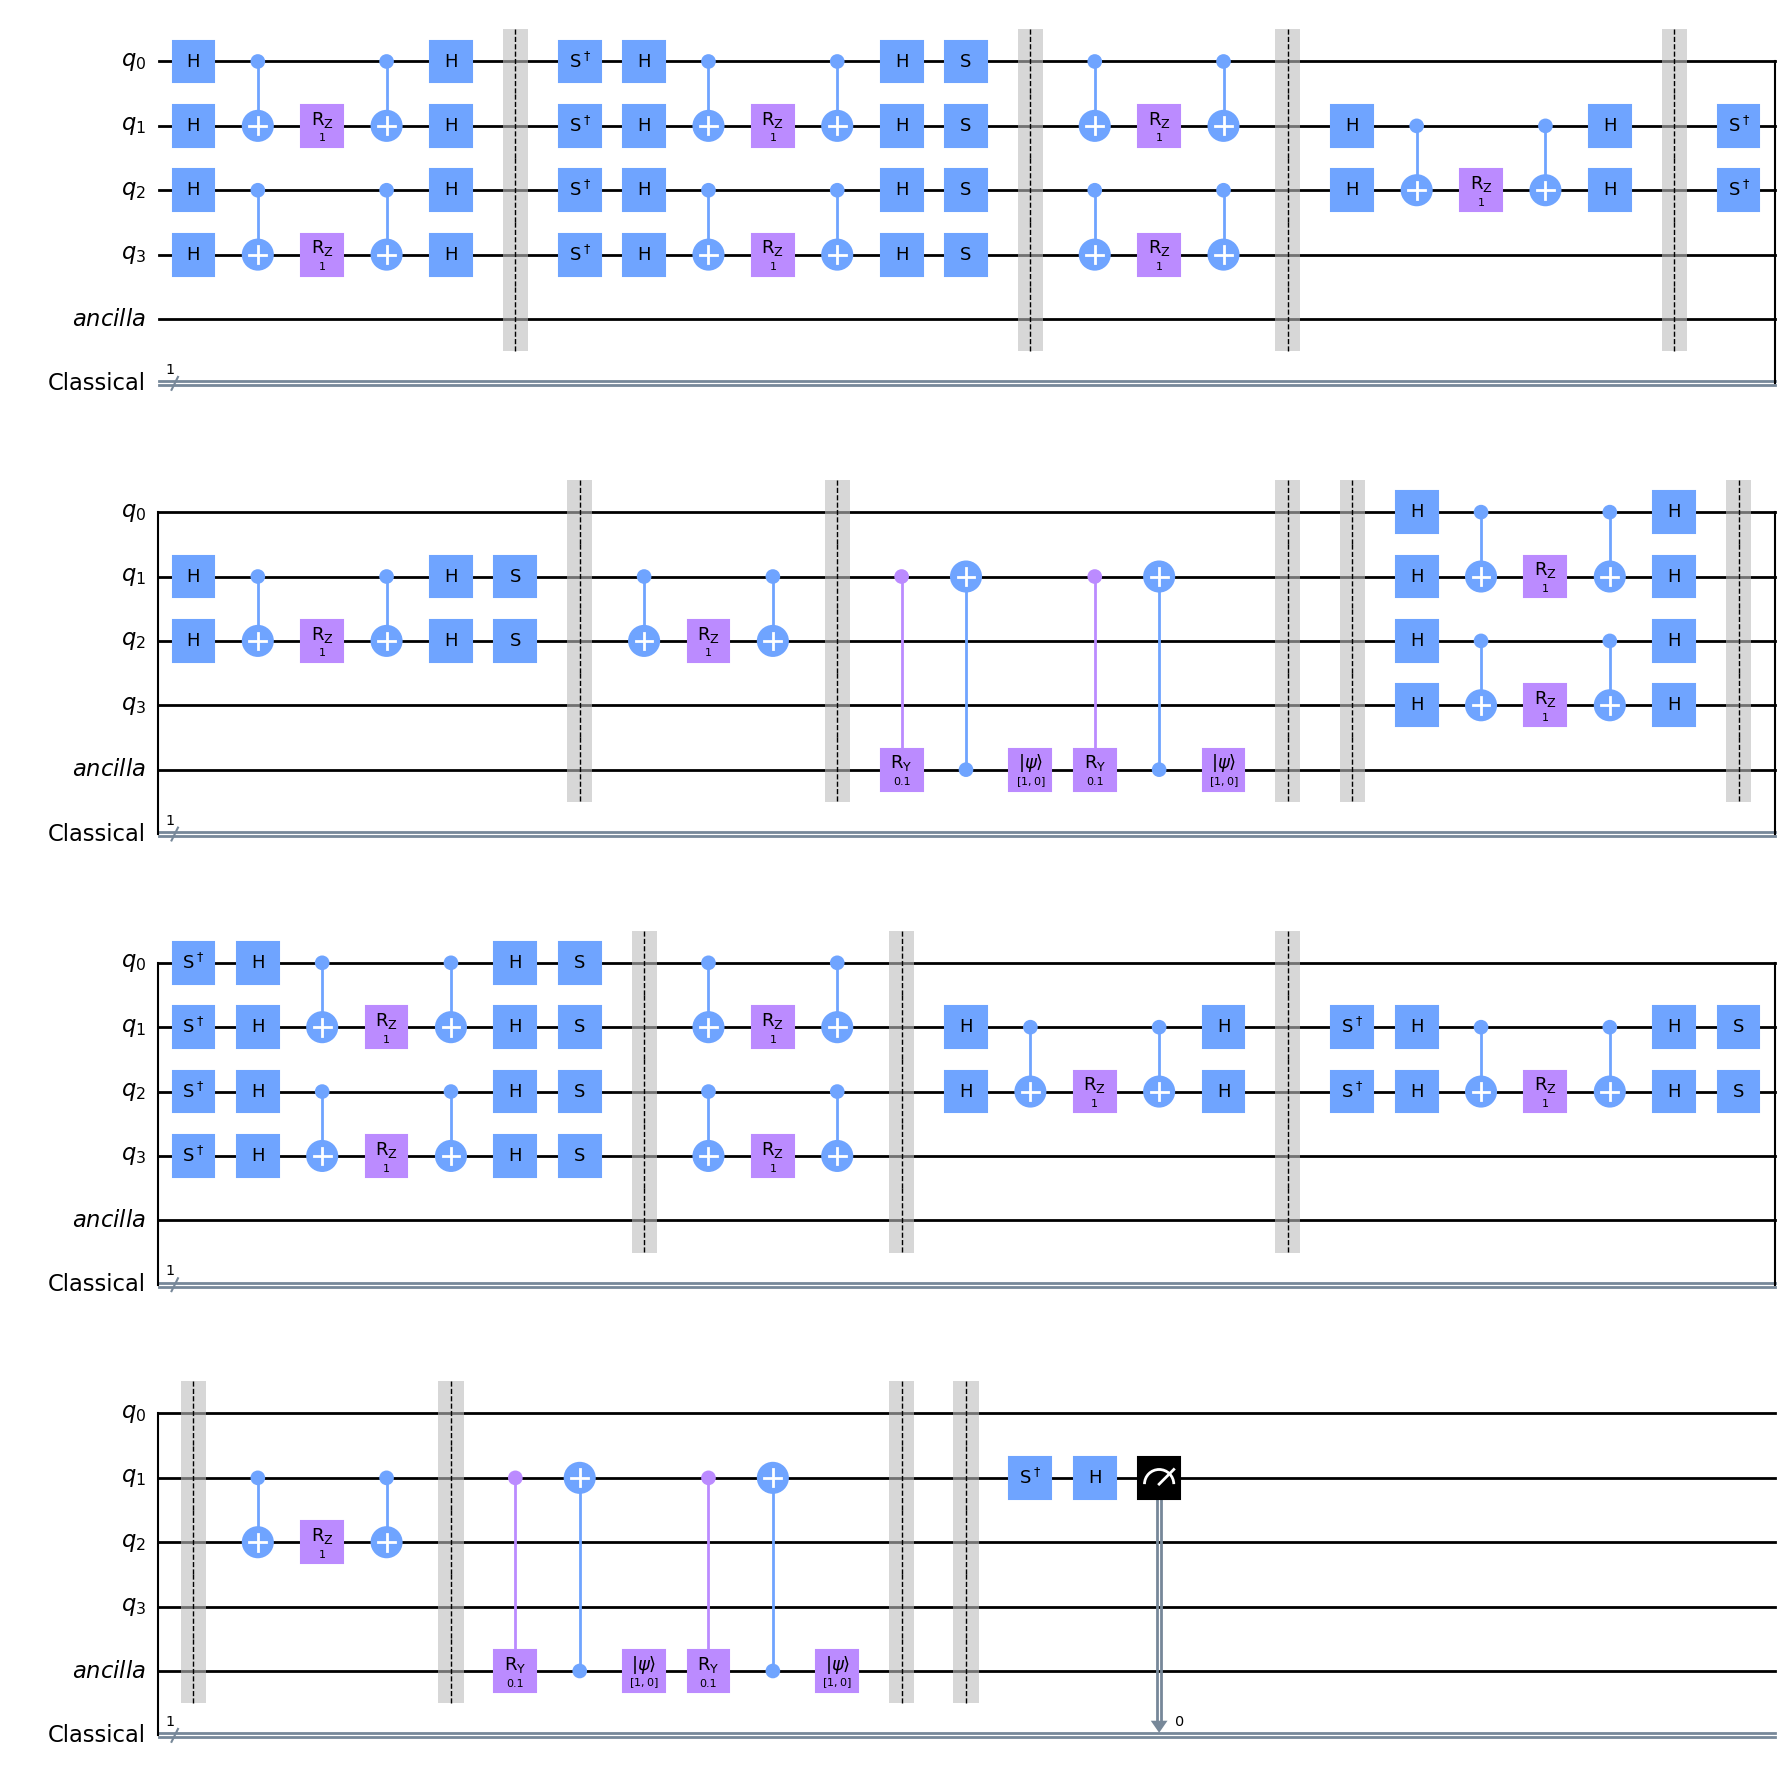

In [108]:
def z_1_circuit(time_step,duration):
    steps = int(duration/time_step)
    qr = QuantumRegister(L,"q")
    
    # Create the ancilla register
    anc = QuantumRegister(1,"ancilla")
    
    # Create a classical register for classical bits
    classical_register = ClassicalRegister(1,"Classical")
    # Create the quantum circuit
    qc = QuantumCircuit(qr, anc,classical_register)
    for i in range(steps):
        qc = qc.compose(one_time_step(time_step))
        qc.barrier()
        qc.barrier()
    qc.sdg(1)    
    qc.h(1)
    qc.measure(1,0)
    return qc
z_1_circuit(0.5,1).draw("mpl")

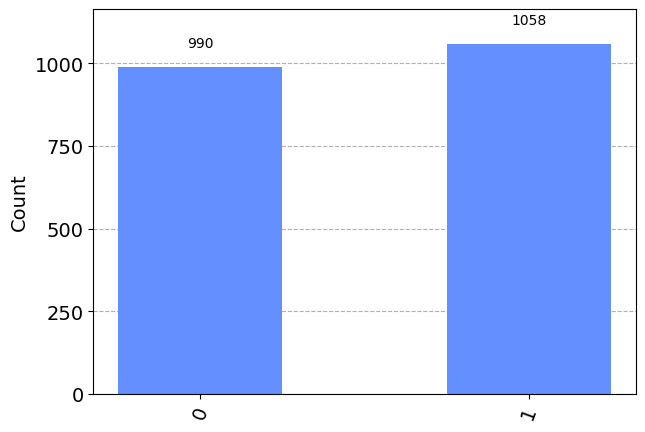

In [110]:
QC = z_1_circuit(0.5,1)
# Simulating the Circuit:
backend = Aer.get_backend('qasm_simulator')
job = execute(QC, backend, shots = 2048)
result = job.result()
counts = result.get_counts()
plot_histogram(counts)

In [85]:
print("Expectation value of X_1 operator = ",(counts['0']-counts['1'])/2048)

Expectation value of X_1 operator =  0.0224609375


# $<Z_{1}Z_{2}>$

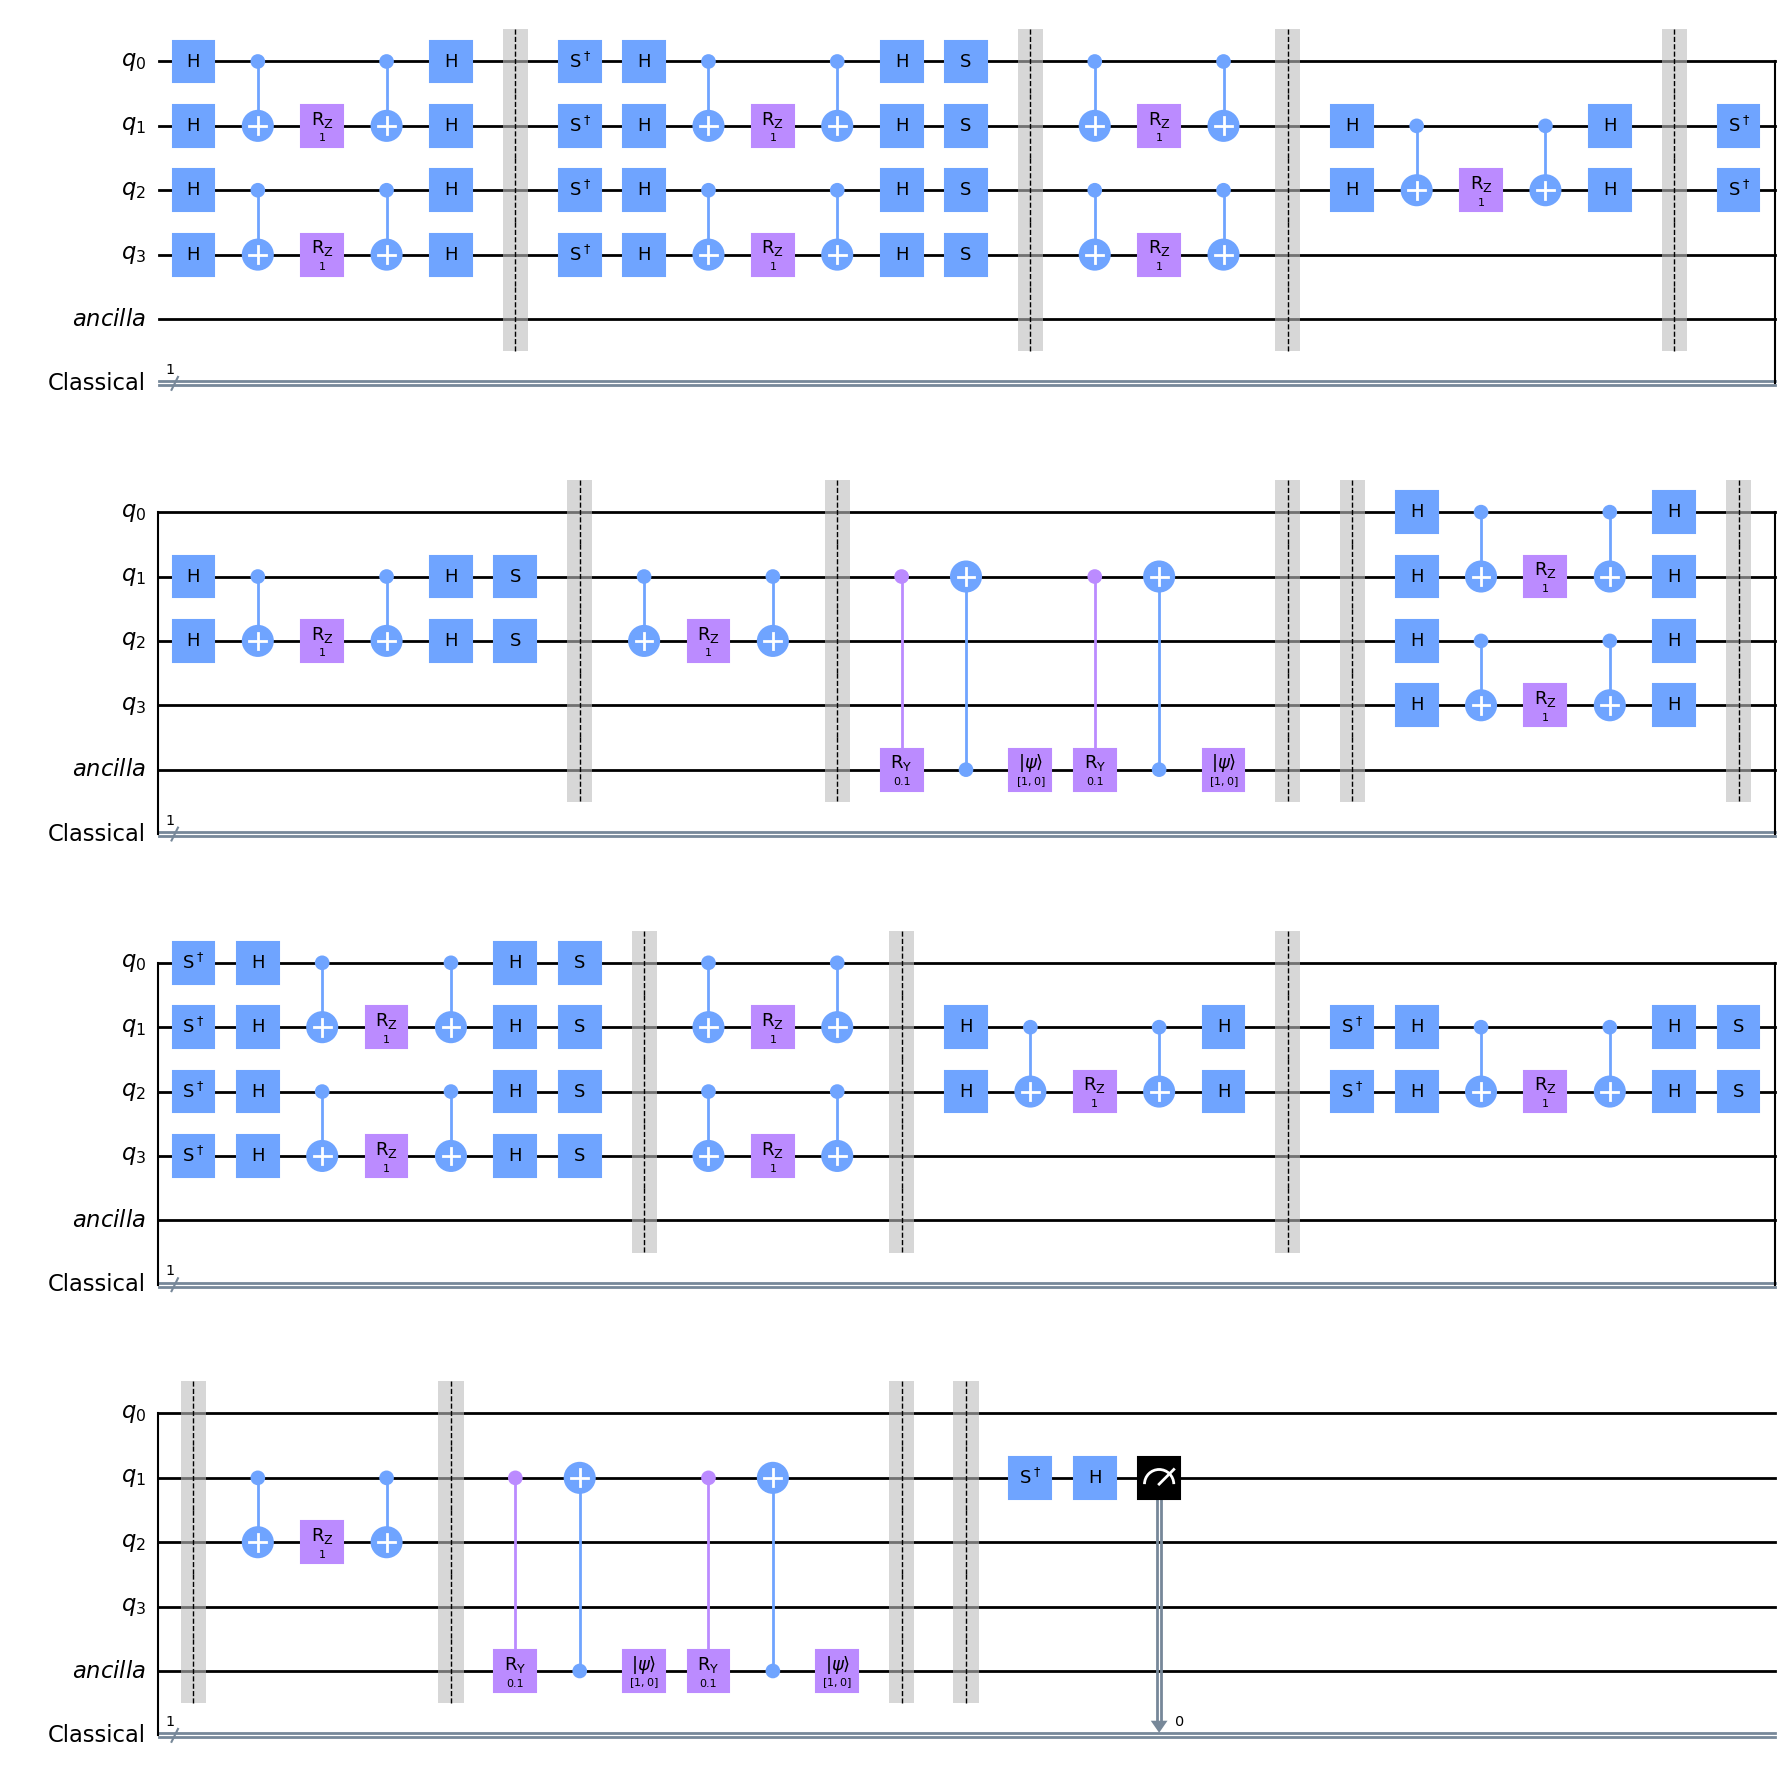

In [113]:
def z_1_z_2_circuit(time_step,duration):
    steps = int(duration/time_step)
    qr = QuantumRegister(L,"q")
    
    # Create the ancilla register
    anc = QuantumRegister(1,"ancilla")
    
    # Create a classical register for classical bits
    classical_register = ClassicalRegister(2,"Classical")
    # Create the quantum circuit
    qc = QuantumCircuit(qr, anc,classical_register)
    for i in range(steps):
        qc = qc.compose(one_time_step(time_step))
        qc.barrier()
        qc.barrier()
    #qc.sdg(1)    
    #qc.h(1)
    qc.measure(1,0)
    qc.measure(3,1)
    return qc
time_evolution_circuit(0.5,1).draw("mpl")

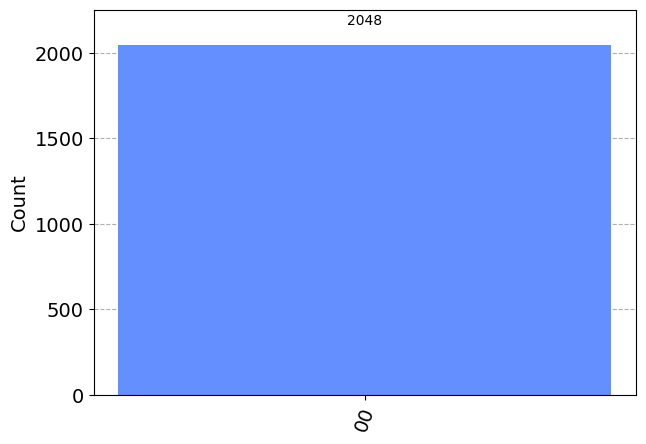

In [115]:
QC =  z_1_z_2_circuit(0.5,1)
# Simulating the Circuit:
backend = Aer.get_backend('qasm_simulator')
job = execute(QC, backend, shots = 2048)
result = job.result()
counts = result.get_counts()
plot_histogram(counts)

# Real Quantum computer

In [69]:
r"""
# Load IBM Q account and get the least busy backend device
provider = IBMQ.load_account()
provider = IBMQ.get_provider("ibm-q")
device = least_busy(provider.backends(filters=lambda x: int(x.configuration().n_qubits) >= 3 and 
                                   not x.configuration().simulator and x.status().operational==True))
print("Running on current least busy device: ", device)""";

In [70]:
r"""
# Run our circuit on the least busy backend. Monitor the execution of the job in the queue
from qiskit.tools.monitor import job_monitor
transpiled_circuit = transpile(time_evolution_circuit(1,1), device, optimization_level=3)
job = device.run(transpiled_circuit)
job_monitor(job, interval=2)""";

In [71]:
r"""
# Getting the results from the computation:
results = job.result()
answer = results.get_counts(transpiled_circuit)
plot_histogram(answer)""";